In [ ]:

import pandas as pd

# Load the dataset using the correct variable name
forest_data = pd.read_csv('/content/forestdata.csv')

# Display the first 8 rows using the correct method on the DataFrame
print("First 8 rows:")
print(forest_data.head())  # Use forest_data.head() to view rows from the DataFrame


First 8 rows:
   collector.id  c.score   l.score      rain  tree.age  surface.litter  \
0             5    13.11  3.421591  0.477187     34.66        6.718047   
1             7    11.99  2.874611  0.212425     19.39        6.242029   
2             6    12.91  2.827774  0.118141     15.75        6.397929   
3             5    12.06  2.772961  0.097565     13.25        6.278146   
4             2    15.06  3.271684  0.438121     47.14        6.932448   

   wind.intensity  humidity  tree.density  month time.of.day  fire  
0        3.335635      52.0       0.69860      8   afternoon     1  
1        3.127024      59.0       0.62020      4     morning     0  
2        3.052446      60.0       0.58235     10       night     0  
3        3.114239      60.0       0.57025      9   afternoon     1  
4        3.214831      51.0       0.71150      7     morning     1  


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Load the dataset
forest_data = pd.read_csv('/content/forestdata.csv')

# Imputing missing values for numerical columns
num_columns = forest_data.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='mean')
forest_data[num_columns] = imputer.fit_transform(forest_data[num_columns])

# One-hot encoding for the 'time.of.day' categorical column
encoder = OneHotEncoder(sparse_output=False)
time_of_day_encoded = encoder.fit_transform(forest_data[['time.of.day']])
time_of_day_encoded_df = pd.DataFrame(time_of_day_encoded, columns=encoder.get_feature_names_out(['time.of.day']))

# Drop the original 'time.of.day' column and concatenate the new one-hot encoded columns
forest_data_preprocessed = pd.concat([forest_data.drop(columns=['time.of.day']), time_of_day_encoded_df], axis=1)

# Define features (X) and target (y)
X = forest_data_preprocessed.drop(columns=['fire'])
y = forest_data_preprocessed['fire']

# First split: Divide the data into a temporary training set and a combined validation/test set (85/15 split)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: Divide the temporary training set into final training and validation sets (82.35/17.65 split of the 85% temp data to achieve 70/15/15 overall split)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)  # 0.1765 ≈ 15/85

# Display the shapes of the splits
print("Shapes of the splits:")
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Shapes of the splits:
Training set: (318, 14) (318,)
Validation set: (69, 14) (69,)
Test set: (69, 14) (69,)


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Load the dataset
forest_data = pd.read_csv('/content/forestdata.csv')

# Imputing missing values for numerical columns
num_columns = forest_data.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='mean')
forest_data[num_columns] = imputer.fit_transform(forest_data[num_columns])

# One-hot encoding for the 'time.of.day' categorical column
encoder = OneHotEncoder(sparse_output=False)
time_of_day_encoded = encoder.fit_transform(forest_data[['time.of.day']])
time_of_day_encoded_df = pd.DataFrame(time_of_day_encoded, columns=encoder.get_feature_names_out(['time.of.day']))

# Drop the original 'time.of.day' column and concatenate the new one-hot encoded columns
forest_data_preprocessed = pd.concat([forest_data.drop(columns=['time.of.day']), time_of_day_encoded_df], axis=1)

# Define features (X) and target (y)
X = forest_data_preprocessed.drop(columns=['fire'])
y = forest_data_preprocessed['fire']

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1875, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Create the Logistic Regression model
log_reg = LogisticRegression(max_iter=5000, solver='liblinear')

# Perform grid search cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
y_pred_log_reg = best_model.predict(X_test_scaled)

# Evaluate the model's performance
print("Logistic Regression Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Precision:", precision_score(y_test, y_pred_log_reg))
print("Recall:", recall_score(y_test, y_pred_log_reg))
print("F1-score:", f1_score(y_test, y_pred_log_reg))

# Plot the confusion matrix
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)

plt.figure(figsize=(7, 7))
sns.heatmap(cm_log_reg, annot=True, fmt="d", cmap="Reds", xticklabels=["Fire Likely", "Fire Unlikely"], yticklabels=["Fire Likely", "Fire Unlikely"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


Best Hyperparameters: {'C': 1, 'penalty': 'l1'}
Logistic Regression Model:
Accuracy: 0.8695652173913043
Precision: 0.8823529411764706
Recall: 0.7894736842105263
F1-score: 0.8333333333333333


NameError: name 'plt' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=5000, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluate the model's performance
print("Logistic Regression Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Precision:", precision_score(y_test, y_pred_log_reg))
print("Recall:", recall_score(y_test, y_pred_log_reg))
print("F1-score:", f1_score(y_test, y_pred_log_reg))

# Plot the confusion matrix
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)

plt.figure(figsize=(7, 7))
sns.heatmap(cm_log_reg, annot=True, fmt="d", cmap="Reds", xticklabels=["Fire Unlikely", "Fire Likely"], yticklabels=["Fire Unlikely", "Fire Likely"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


Logistic Regression Model:
Accuracy: 0.8586956521739131
Precision: 0.8571428571428571
Recall: 0.7894736842105263
F1-score: 0.8219178082191781


<Figure size 800x600 with 0 Axes>

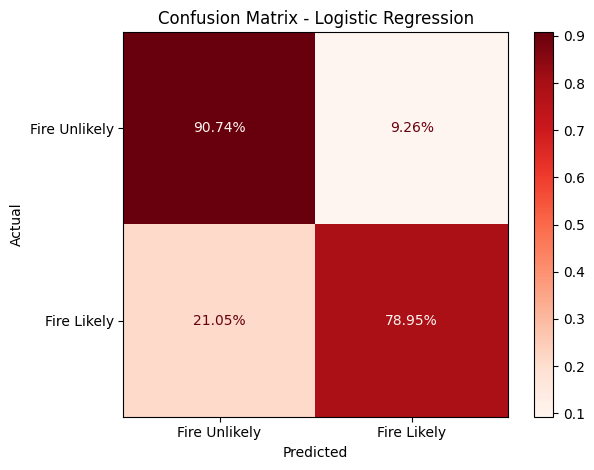

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=5000, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluate the model's performance
print("Logistic Regression Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Precision:", precision_score(y_test, y_pred_log_reg))
print("Recall:", recall_score(y_test, y_pred_log_reg))
print("F1-score:", f1_score(y_test, y_pred_log_reg))

# Create the confusion matrix
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)

# Normalize the confusion matrix to convert counts to percentages
cm_log_reg_percentage = cm_log_reg.astype('float') / cm_log_reg.sum(axis=1)[:, np.newaxis]

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg_percentage, display_labels=["Fire Unlikely", "Fire Likely"])

# Customize the confusion matrix visualization
plt.figure(figsize=(8, 6))
disp.plot(cmap="Reds", values_format=".2%")
disp.ax_.set_title("Confusion Matrix - Logistic Regression")
disp.ax_.set_xlabel("Predicted")
disp.ax_.set_ylabel("Actual")
plt.tight_layout()
plt.show()



Decision Tree model
Accuracy: 0.8586956521739131
Precision: 0.8378378378378378
recall: 0.8157894736842105
F1 0.8266666666666665


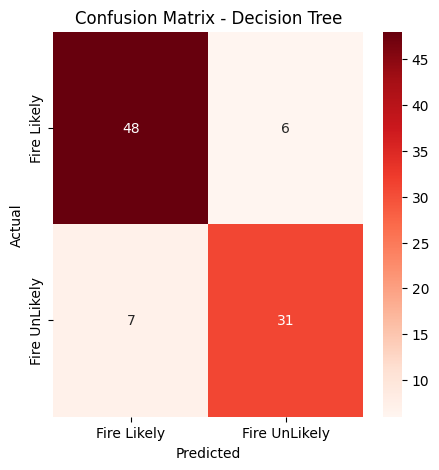

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Building the Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Predictions on the test set
y_pred_dt = decision_tree.predict(X_test)

# Evaluation
print("Decision Tree model")
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy:",accuracy_dt)
precision_dt = precision_score(y_test, y_pred_dt)
print("Precision:",precision_dt)
recall_dt = recall_score(y_test, y_pred_dt)
print("recall:",recall_dt)
f1_dt = f1_score(y_test, y_pred_dt)
print("F1",f1_dt)


accuracy_dt, precision_dt, recall_dt, f1_dt

# Assuming y_pred_dt contains predictions from the decision tree model
cm_dt = confusion_matrix(y_test, y_pred_dt)


plt.figure(figsize=(5, 5))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Reds", xticklabels=["Fire Likely", "Fire UnLikely"], yticklabels=["Fire Likely", "Fire UnLikely"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

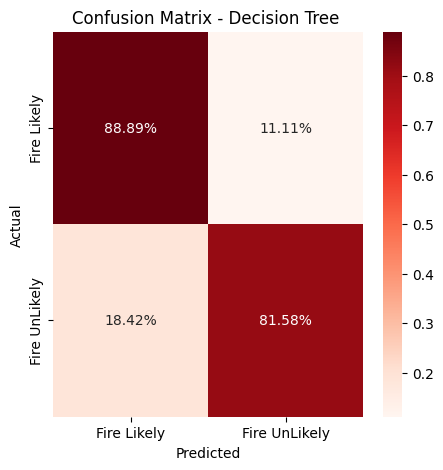

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace 'y_test' and 'y_pred_dt' with your actual test labels and Decision Tree predictions
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Normalize the confusion matrix to convert counts to percentages
cm_dt_percentage = cm_dt.astype('float') / cm_dt.sum(axis=1)[:, np.newaxis]

# Plotting
plt.figure(figsize=(5, 5))
sns.heatmap(cm_dt_percentage, annot=True, fmt=".2%", cmap="Reds", xticklabels=["Fire Likely", "Fire UnLikely"], yticklabels=["Fire Likely", "Fire UnLikely"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Decision Tree ')
plt.show()

Decision Tree Model:
Accuracy: 0.8695652173913043
Precision: 0.8611111111111112
Recall: 0.8157894736842105
F1-score: 0.8378378378378377


<Figure size 800x600 with 0 Axes>

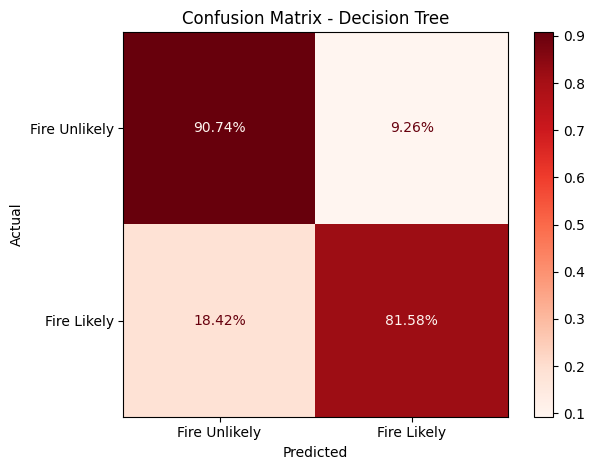

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Train the Decision Tree model
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_dt = dt.predict(X_test_scaled)

# Evaluate the model's performance
print("Decision Tree Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1-score:", f1_score(y_test, y_pred_dt))

# Create the confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Normalize the confusion matrix to convert counts to percentages
cm_dt_percentage = cm_dt.astype('float') / cm_dt.sum(axis=1)[:, np.newaxis]

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt_percentage, display_labels=["Fire Unlikely", "Fire Likely"])

# Customize the confusion matrix visualization
plt.figure(figsize=(8, 6))
disp.plot(cmap="Reds", values_format=".2%")
disp.ax_.set_title("Confusion Matrix - Decision Tree")
disp.ax_.set_xlabel("Predicted")
disp.ax_.set_ylabel("Actual")
plt.tight_layout()
plt.show()


Neutral Networks
Accuracy: 0.8804347826086957
precision: 0.8292682926829268
recall: 0.8947368421052632
F1: 0.860759493670886


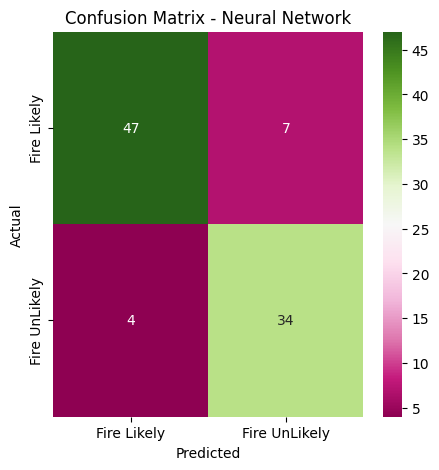

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Scaling the features for the neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building the Neural Network model with MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred_mlp = mlp.predict(X_test_scaled)

# Evaluation
print("Neutral Networks")

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print("Accuracy:",accuracy_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
print("precision:",precision_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
print("recall:",recall_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)
print("F1:",f1_mlp)

accuracy_mlp, precision_mlp, recall_mlp, f1_mlp

# Assuming y_pred_mlp contains predictions from the MLPClassifier model
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

plt.figure(figsize=(5, 5))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="PiYG", xticklabels=["Fire Likely", "Fire UnLikely"], yticklabels=["Fire Likely", "Fire UnLikely"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Neural Network')
plt.show()



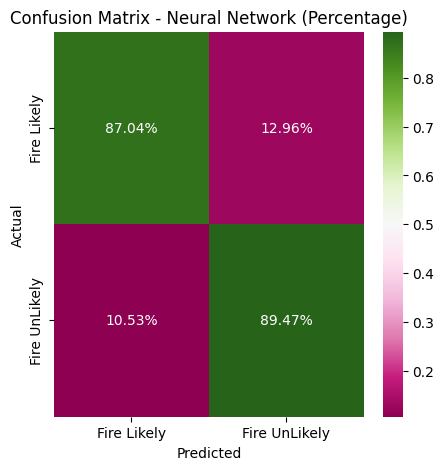

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_pred_mlp contains predictions from the MLPClassifier model
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

# Normalize the confusion matrix to show percentages
cm_mlp_percentage = cm_mlp.astype('float') / cm_mlp.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5, 5))
sns.heatmap(cm_mlp_percentage, annot=True, fmt=".2%", cmap="PiYG", xticklabels=["Fire Likely", "Fire UnLikely"], yticklabels=["Fire Likely", "Fire UnLikely"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Neural Network (Percentage)')
plt.show()